In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# entering the directory
%cd /content/drive/MyDrive/ICSA_DLcourse/quantile

In [1]:
%load_ext autoreload
%autoreload 2

from generate import *
from model import DQRP,DQR,DQR_NC
from functions import train_multi,train_process
from plot import plot
from train import train_test

import torch
import matplotlib.pyplot as plt
import numpy as np

# Plotting the ground truth

In [17]:
SIZE=2**9; taus=torch.Tensor([0.05,0.25,0.5,0.75,0.95]).unsqueeze(1);
models=['linear','wave','triangle']
modelnames=['Linear','Wave','Angle']
errornames=[r'$t(3)$','Exp','Sine']
dataset=[]
x0=torch.linspace(0,1,1000).unsqueeze(dim=1);x=[];y=[];quant0=[]
for model in models:
    dataset=gen_univ(size=SIZE,model=model,error='t',df=2,sigma=1)
    x.append(dataset[:][0].data.numpy())
    y.append(dataset[:][1].data.numpy())
    quant0.append(quant_univ(x0,taus,model=model,error='t',df=2,sigma=1))
ylims=[[-6,7],[-6,5],[1,6.5]]
positions=['upper left','lower left','upper left']
#colors=['r','darkorange','lime','darkviolet','deepskyblue']
names=(r'$\tau=0.05$',r'$\tau=0.25$',r'$\tau=0.5$',r'$\tau=0.75$',r'$\tau=0.95$','Data')

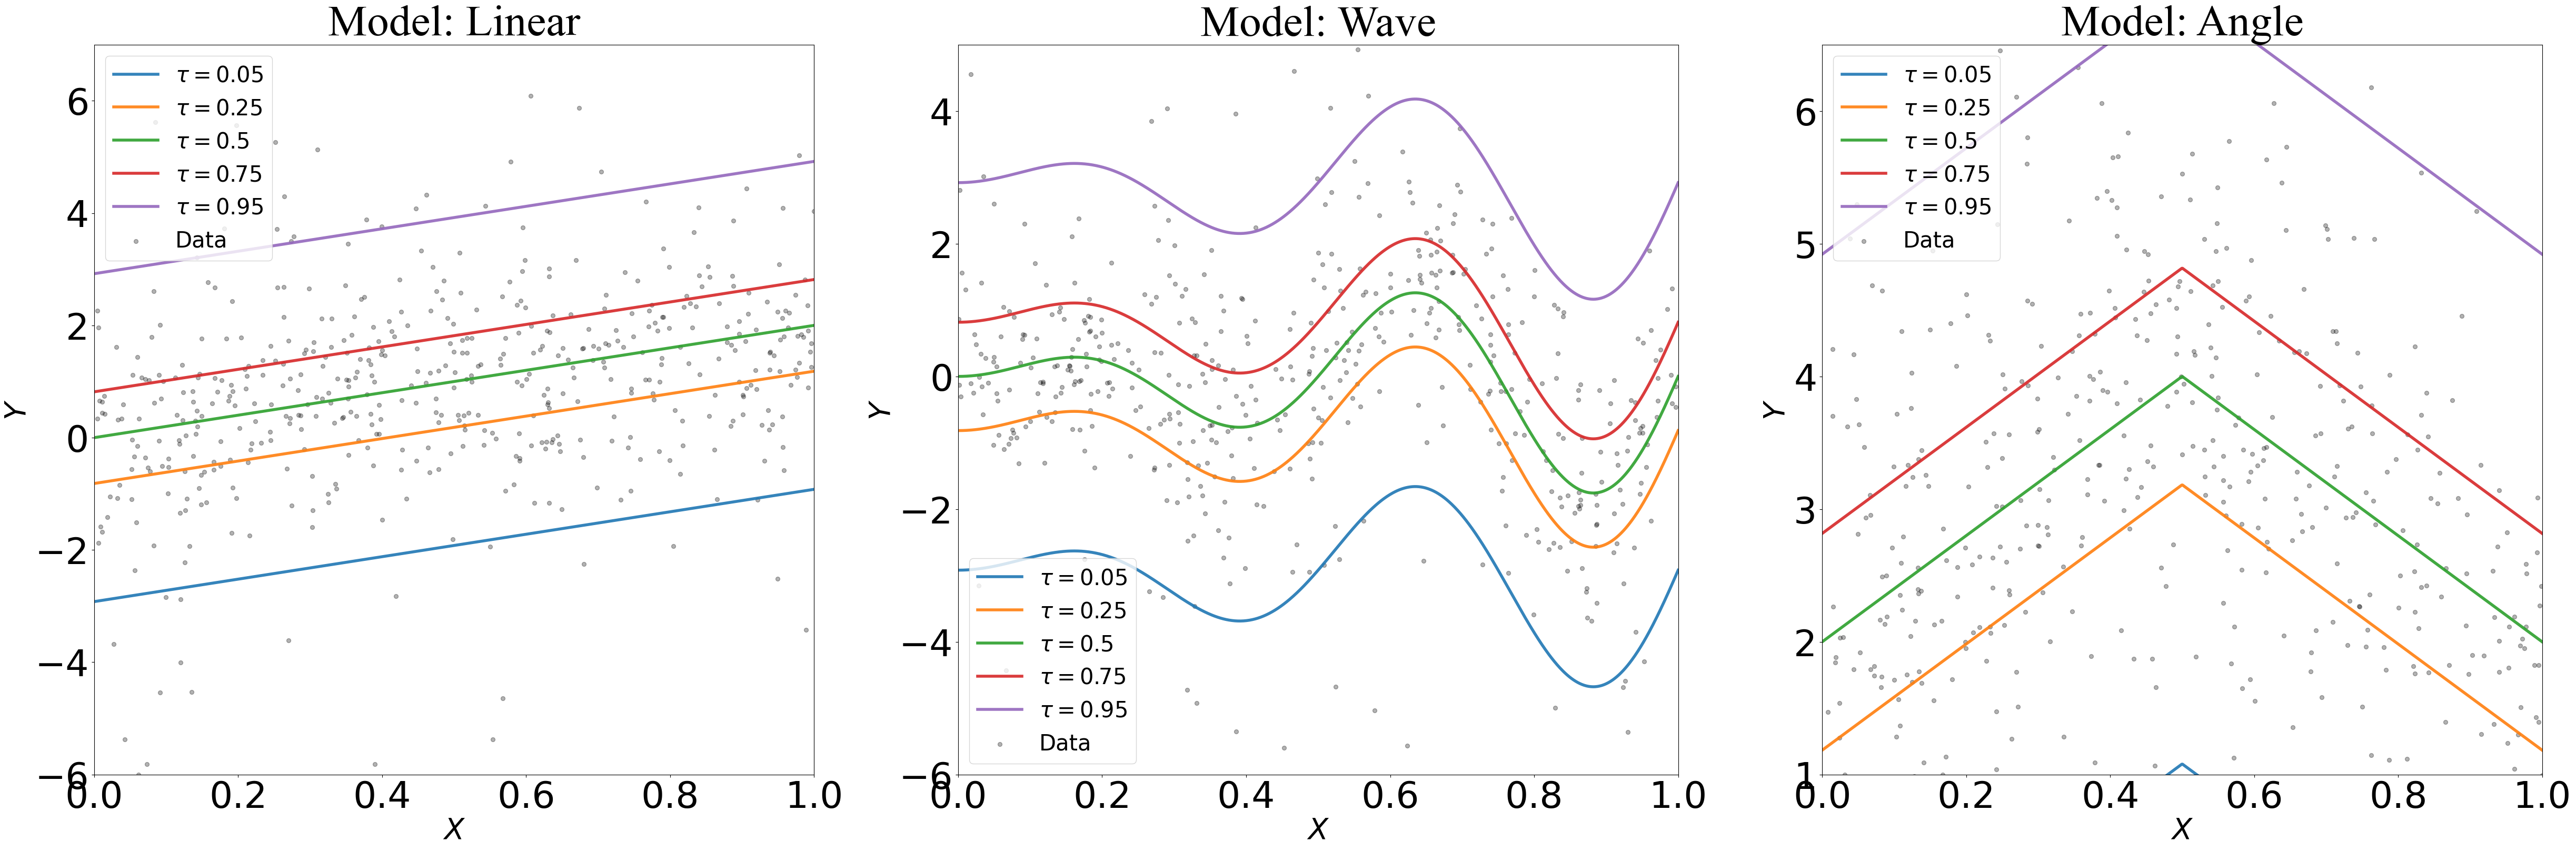

In [18]:
figs, axs = plt.subplots(1,len(models),figsize=(60,18))
#ticksize=15;titlesize=32;llw=3;dlw=3;

for i in range(len(models)):
    axs[i].tick_params(axis='both', which='major', labelsize=50)
    axs[i].set_title('Model: %s'% (modelnames[i]),fontdict={'family':'Times New Roman','size':60})
    axs[i].set_xlabel(r'$X$', fontdict={'family': 'Times New Roman', 'size': 40})
    axs[i].set_ylabel(r'$Y$', fontdict={'family': 'Times New Roman', 'size': 40})
    axs[i].set_xlim(0, 1)
    axs[i].set_ylim(ylims[i])
    axs[i].plot(x0, quant0[i], alpha=0.9,lw=4)
    axs[i].scatter(x[i], y[i], color = "k", alpha=0.3,label='Data',s=32)
    axs[i].legend(names,loc=positions[i],fontsize=30)

# Defining the models

### DQR and DQR*

Naive DQR model just outputs $K$ values as quantiles while DQR* model improves over DQR by using $\log(1+exp(x))$ transformation to get non-negative gaps. By doing so, DQR* guarantees the non-crossingness of the quantiles.

In [4]:
class DQR(torch.nn.Module):
    def __init__(self, width_vec: list = None, Noncrossing = False):
        super(DQR, self).__init__()
        self.width_vec= width_vec
        self.Noncrossing = Noncrossing
        modules = []
        if width_vec is None:
            width_vec = [256, 256, 256]
    
        for i in range(len(width_vec) - 2):
                modules.append(
                    nn.Sequential(
                        nn.Linear(width_vec[i],width_vec[i+1]),
                        nn.ReLU()))

        self.net = nn.Sequential(*modules,
                                 nn.Linear(width_vec[-2],width_vec[-1]))

    def forward(self,x):
            if self.Noncrossing == False:
                output = self.net(x)
            if self.Noncrossing == True: 
                # Output the smallerst quantile 
                h_0 = self.net(x)[:,0].unsqueeze(1);
                # Output the values for compute gaps among quantiles 
                gaps = self.net(x)[:,1:];
                # Apply positive activation function to the gaps
                gaps = torch.log(1 + torch.exp(gaps))
                # Perform cumsum operation on gaps
                cumsum_gaps = torch.cumsum(gaps, dim=1)
                # Add smallerst quantile and cumsum_output to form the final output vector
                output = torch.cat((h_0,h_0 + cumsum_gaps),dim=1)
                
            return  output
  

### NCQR

![NCQR](images/NCQR.png)

NCQR consists two sub-networks, one generating accumulate values from 0 to 1 the other scales the values to quantiles

In [5]:
class NC_QR(torch.nn.Module):
    def __init__(self, value_layer: list = None, delta_layer:list = None):
        super(NC_QR, self).__init__()
        self.value_layer = value_layer
        self.delta_layer = delta_layer        
        if value_layer is None:
            value_layer = [256, 256, 256];
        if delta_layer is None:
            delta_layer = [256, 256, 256];

        # Q Network
        q_layers = []
        for i in range(len(value_layer) - 2):
            q_layers.append(
                nn.Sequential(
                    nn.Linear(value_layer[i],value_layer[i+1]),
                    nn.ReLU()))

        # Weight Network
        weight_layers = []
        for i in range(len(delta_layer) - 2):
            weight_layers.append(
                nn.Sequential(
                    nn.Linear(delta_layer[i],delta_layer[i+1]),
                    nn.ReLU()))

        self.weight = nn.Sequential(*weight_layers, nn.Linear(delta_layer[-2], 2))      
        self.q_net = nn.Sequential(*q_layers,nn.Linear(value_layer[-2], value_layer[-1]), nn.Softmax())
                                 
    def forward(self, x):
        quantiles = self.q_net(x)
        weight = self.weight(x)
        w = weight[:,0].unsqueeze(dim=1).expand(quantiles.shape)
        b = weight[:,1].unsqueeze(dim=1).expand(quantiles.shape)
        probs = torch.cumsum(quantiles, dim =1)
        nc_quantities = w*probs +b

        return nc_quantities

       

### NQ_Net

![NQ](images/NQ.png)

NQ-net also have two sub-networks, one models the mean and the other models the non-negative gaps.

In [6]:
class DQR_NC(torch.nn.Module):
    def __init__(self, value_layer: list = None, delta_layer:list = None, activation='ELU'):
        super(DQR_NC, self).__init__()
        self.value_layer = value_layer
        self.delta_layer = delta_layer
        self.activation = activation
        if value_layer is None:
            value_layer = [256, 256, 256];
        if delta_layer is None:
            delta_layer = [256, 256, 256];
        # Value Network
        value_layers = []
        for i in range(len(value_layer) - 2):
                value_layers.append(
                    nn.Sequential(
                        nn.Linear(value_layer[i],value_layer[i+1]),
                        nn.ReLU()))

        self.value = nn.Sequential(*value_layers,nn.Linear(value_layer[-2],value_layer[-1]))
                                 
        # Delta Network
        delta_layers = []
        for i in range(len(delta_layer) - 2):
                delta_layers.append(
                    nn.Sequential(
                        nn.Linear(delta_layer[i],delta_layer[i+1]),
                        nn.ReLU()))

        self.delta = nn.Sequential(*delta_layers, nn.Linear(delta_layer[-2],delta_layer[-1]))
                                 
    def forward(self, x):
        value = self.value(x)
        if self.activation=="ELU":
            delta = torch.nn.functional.elu(self.delta(x))+1;
        if self.activation=="ReLU":
            delta = torch.nn.functional.relu(self.delta(x));
        if self.activation=="log":
            delta = torch.log(1 + torch.exp(self.delta(x)));
        # Perform cumsum operation on delta
        cumsum_delta = torch.cumsum(delta, dim=1)
        # Subtract the mean from elu_output to make the mean 0
        cumsum_delta0 = cumsum_delta - cumsum_delta.mean(dim=1, keepdim=True)
        # Add value and cumsum_output to form the final output vector
        output = value + cumsum_delta0
        return output


# Model training

### Setup

In [7]:
taus = torch.Tensor([0.05,0.25,0.5,0.75,0.95]).unsqueeze(1);
error="t"; d=1;df=2;sigma=1; SIZE=2**9

### linear

In [8]:
data_train= gen_univ(model="linear",size=SIZE,error=error,df=df,sigma=sigma)
data_val= gen_univ(model="linear",size=int(SIZE/4),error=error,df=df,sigma=sigma)
x_test=torch.linspace(0,1,1000).unsqueeze(1)
quants = quant_univ(x_test, taus,model="linear",error=error,df=df,sigma=sigma)

In [9]:
preds = train_test("linear", error, df, sigma, taus)

/Users/leo/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train


  0%|          | 0/1000 [00:00<?, ?it/s]/Users/leo/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 20%|██        | 200/1000 [00:01<00:04, 171.03it/s]


Early stopping!


 23%|██▎       | 230/1000 [00:00<00:03, 231.17it/s]


Early stopping!


 20%|██        | 200/1000 [00:01<00:04, 177.93it/s]


Early stopping!


 20%|██        | 200/1000 [00:00<00:03, 203.66it/s]

Early stopping!


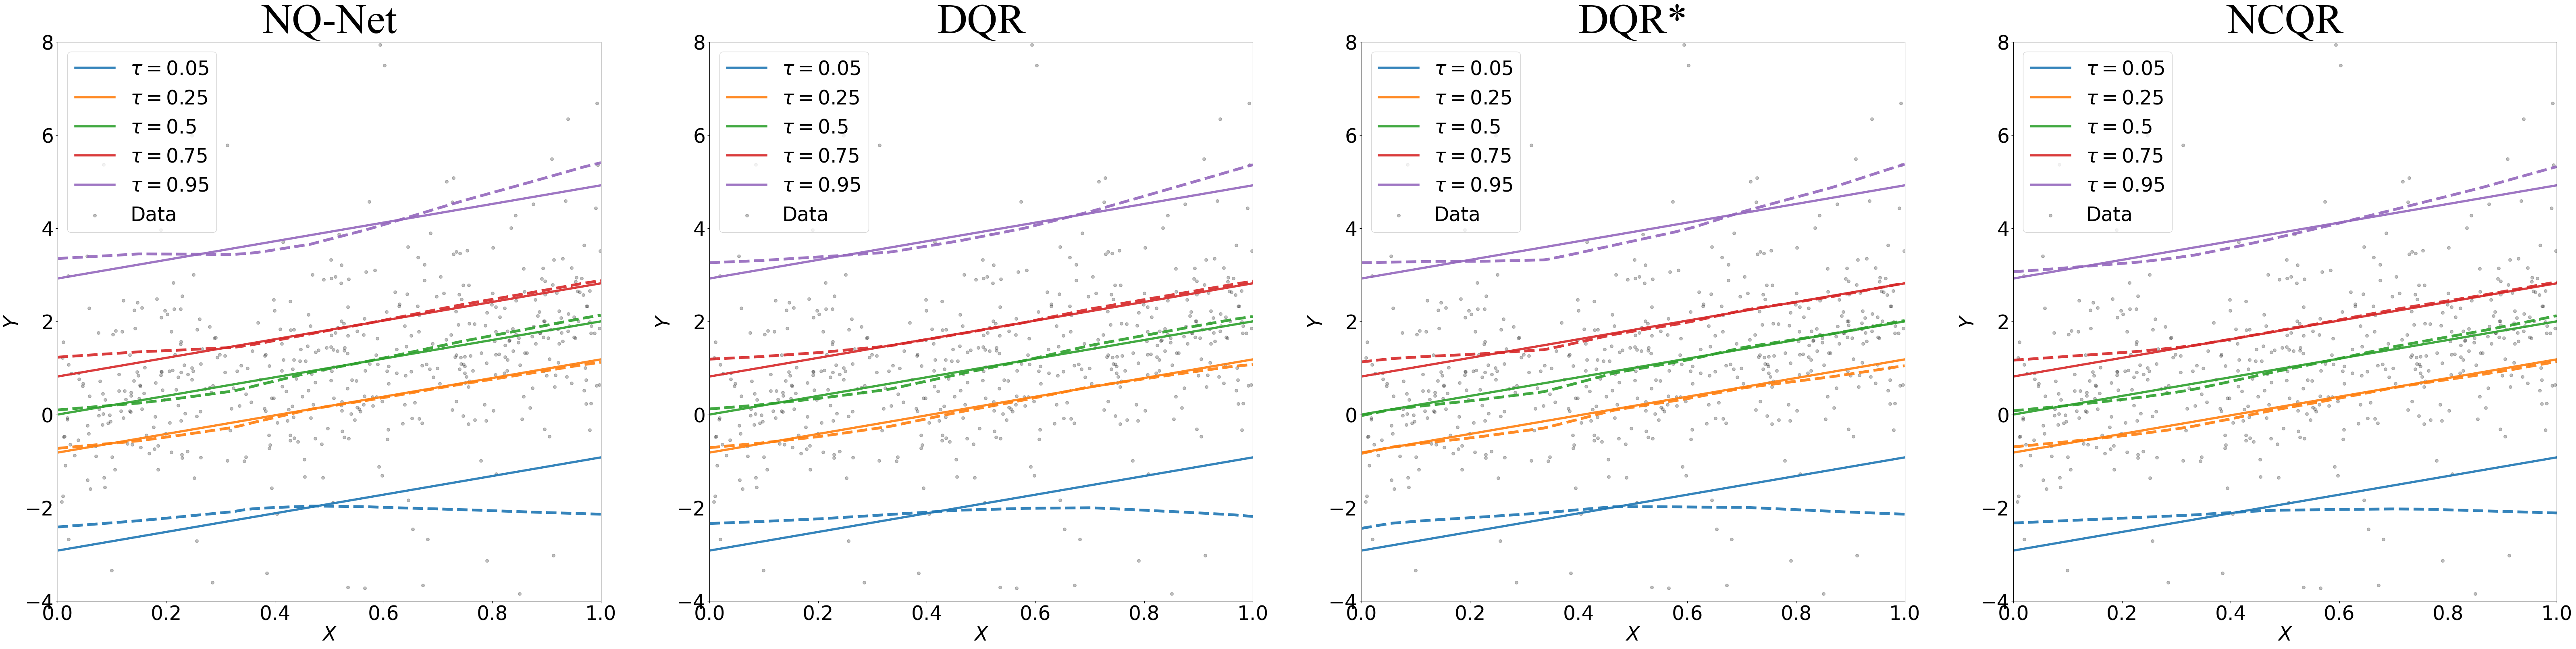

In [10]:
plot(quants, data_train, preds, taus)

### Wave

In [11]:
data_train= gen_univ(model="wave",size=SIZE,error=error,df=df,sigma=sigma)
data_val= gen_univ(model="wave",size=int(SIZE/4),error=error,df=df,sigma=sigma)
x_test=torch.linspace(0,1,1000).unsqueeze(1)
quants = quant_univ(x_test, taus,model="wave",error=error,df=df,sigma=sigma)

In [12]:
preds = train_test("wave", error, df, sigma, taus)

Train


 67%|██████▋   | 669/1000 [00:03<00:01, 196.59it/s]


Early stopping!


 66%|██████▋   | 665/1000 [00:03<00:01, 219.31it/s]


Early stopping!


 78%|███████▊  | 776/1000 [00:04<00:01, 172.70it/s]


Early stopping!


 75%|███████▍  | 748/1000 [00:03<00:01, 209.99it/s]

Early stopping!


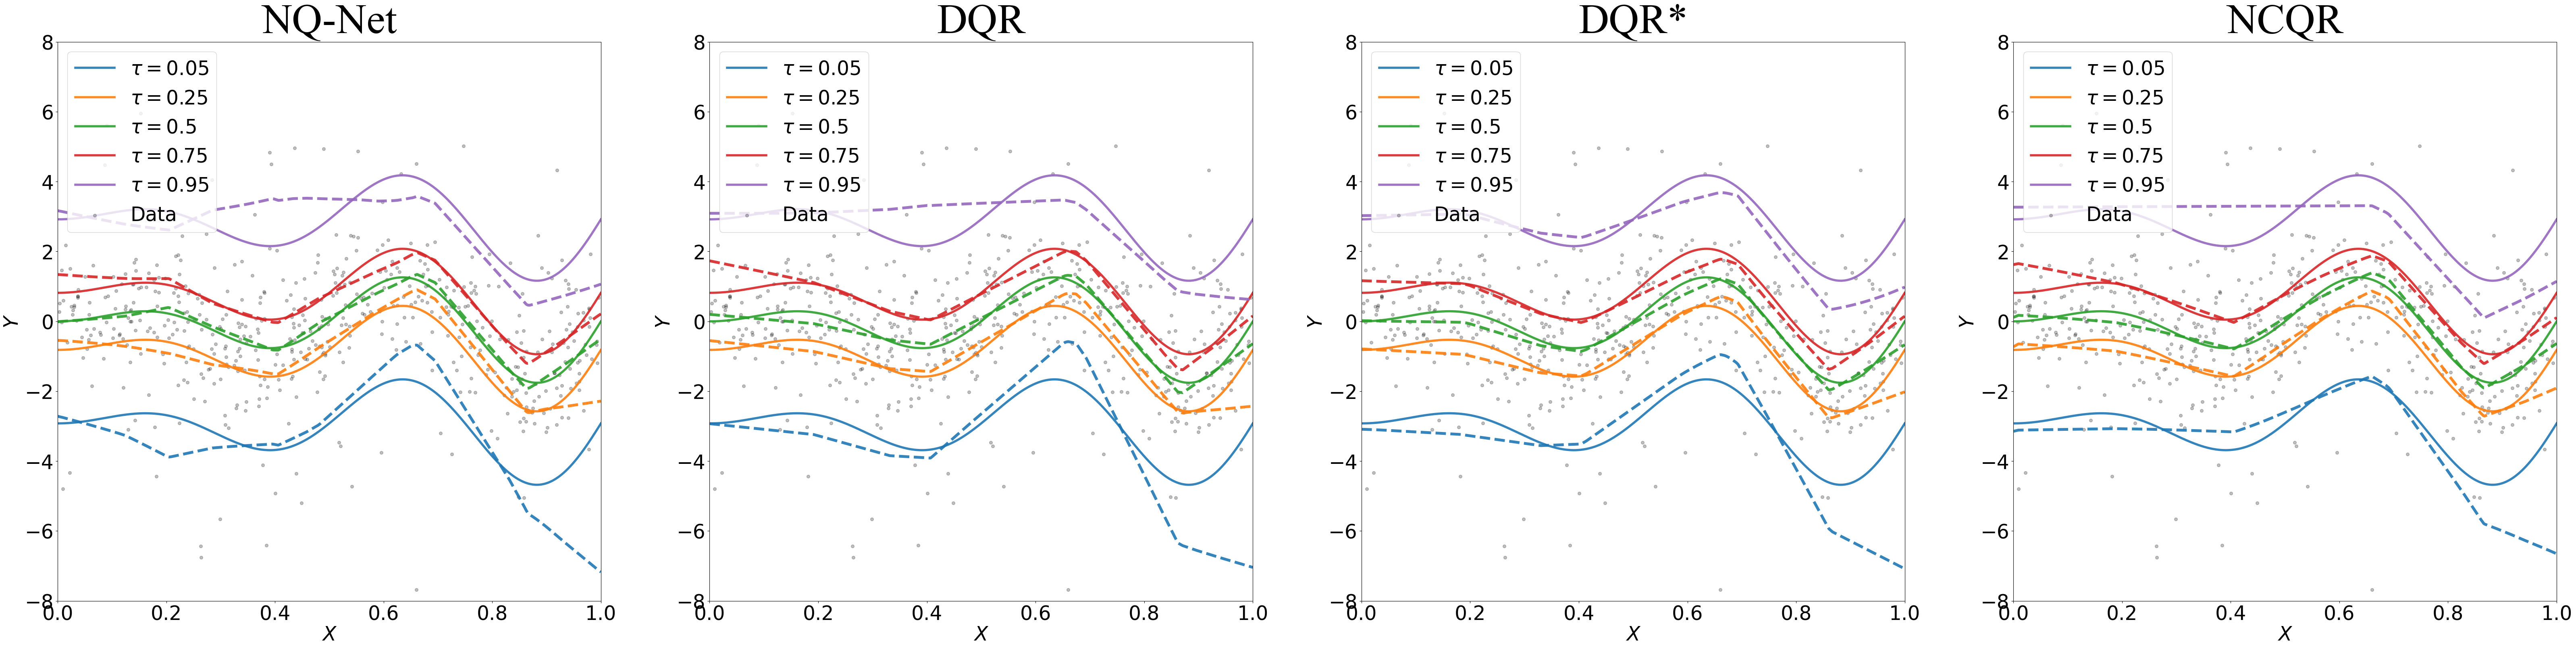

In [20]:
plot(quants, data_train, preds, taus)

### Angle

In [21]:
data_train= gen_univ(model="triangle",size=SIZE,error=error,df=df,sigma=sigma)
data_val= gen_univ(model="triangle",size=int(SIZE/4),error=error,df=df,sigma=sigma)
x_test=torch.linspace(0,1,1000).unsqueeze(1)
quants = quant_univ(x_test, taus,model="triangle",error=error,df=df,sigma=sigma)

In [22]:
preds = train_test("triangle", error, df, sigma, taus)

Train


 26%|██▋       | 264/1000 [00:01<00:04, 181.21it/s]


Early stopping!


 31%|███       | 310/1000 [00:01<00:02, 231.29it/s]


Early stopping!


 33%|███▎      | 331/1000 [00:01<00:03, 179.78it/s]


Early stopping!


 35%|███▌      | 353/1000 [00:01<00:03, 203.00it/s]


Early stopping!


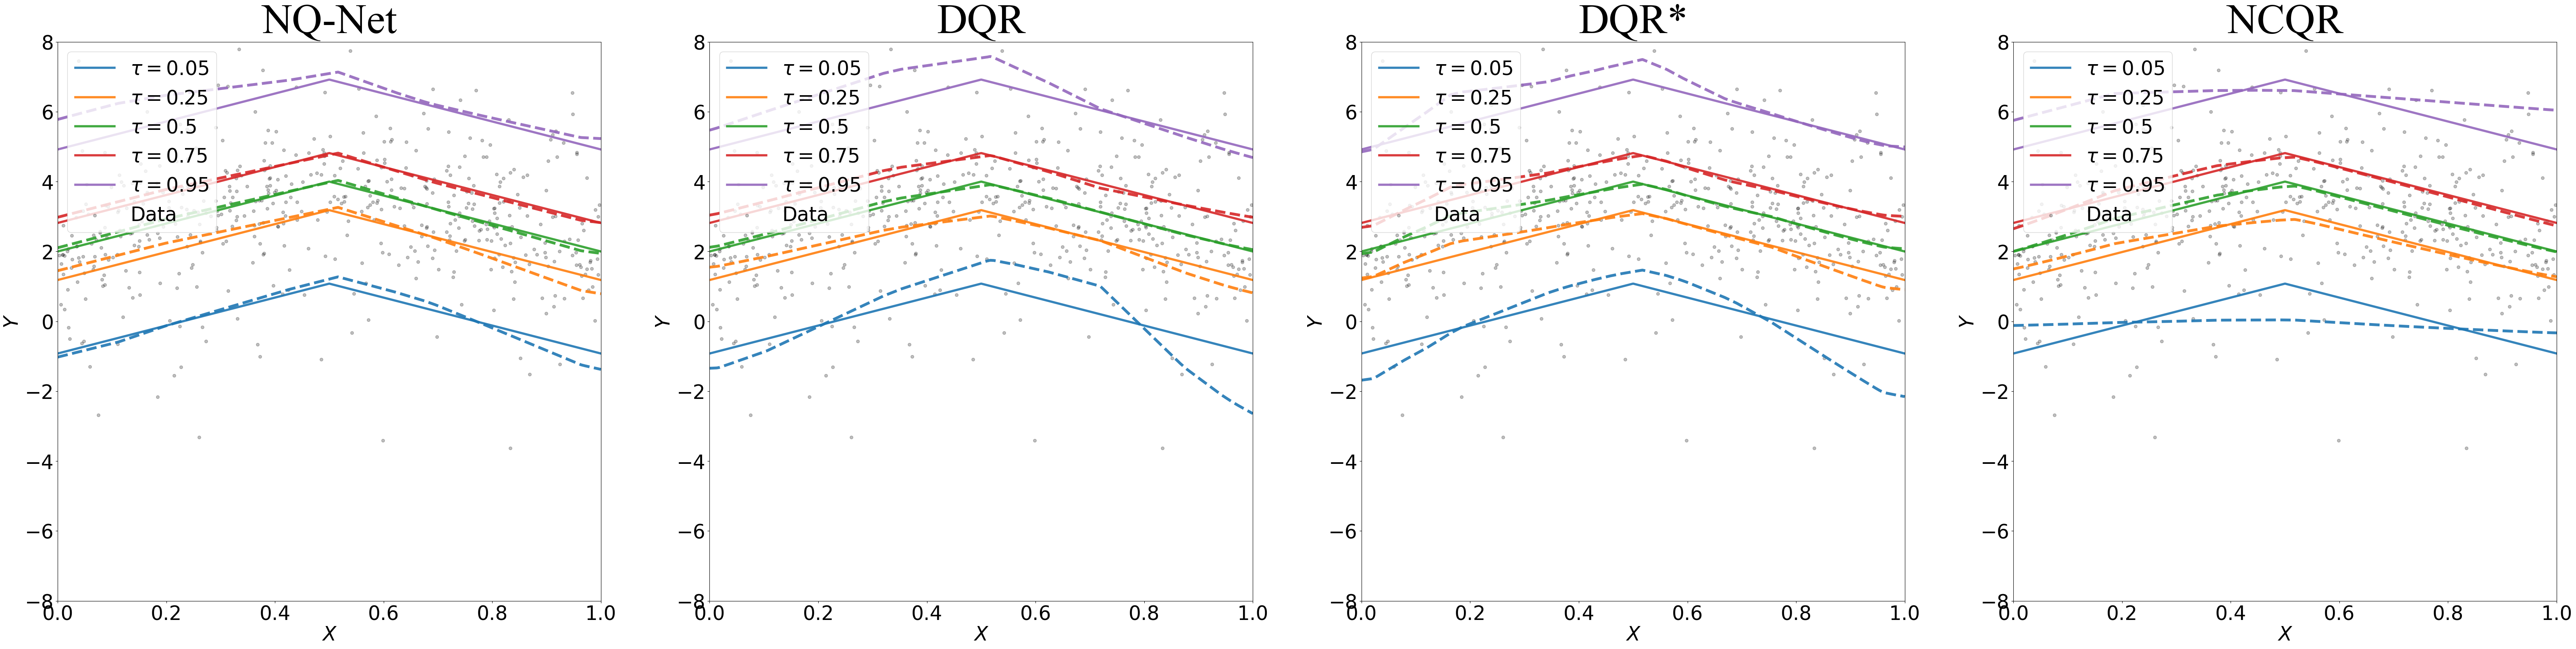

In [23]:
plot(quants, data_train, preds, taus)